In [1]:
import sys
print(sys.executable)


c:\Users\claud\GIT\Proyecto_Hoteles_ETL\venv\Scripts\python.exe


In [ ]:
import pandas as pd
import numpy as np
 
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Para gestión de fechas
# -----------------------------------------------------------------------
from datetime import datetime

In [3]:
# Análisis fichero parquet
 
df_parquet = pd.read_parquet('../data/data_raw/reservas_hoteles.parquet', engine='pyarrow')
df_parquet.head()

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
0,5256cc90-139b-43d2-8ec5-412495d751cf,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Feliciana,Cantón,feliciana.cantón@example.com,True,,2025-03-01,2025-03-02,113,NaN,,NaN,
1,84fd6209-bd8d-4a92-bfe6-c68ee2c49271,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Leonardo,Hierro,leonardo.hierro@example.com,True,,2025-03-01,2025-03-02,194,NaN,,NaN,
2,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,14,119.96,Hotel Monte Verde,1.0,Madrid
3,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,38,211.53,Hotel Brisas del Mar,5.0,Madrid
4,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,35,378.37,Hotel Camino del Sol,1.0,Madrid


In [4]:
# Análisis fichero parquet
 
df = df_parquet.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_reserva       15098 non-null  object 
 1   id_cliente       15098 non-null  object 
 2   nombre           15098 non-null  object 
 3   apellido         15098 non-null  object 
 4   mail             15098 non-null  object 
 5   competencia      15098 non-null  bool   
 6   fecha_reserva    15098 non-null  object 
 7   inicio_estancia  15023 non-null  object 
 8   final_estancia   15023 non-null  object 
 9   id_hotel         15098 non-null  int64  
 10  precio_noche     9874 non-null   float64
 11  nombre_hotel     15098 non-null  object 
 12  estrellas        9926 non-null   float64
 13  ciudad           15098 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(10)
memory usage: 1.5+ MB


In [5]:
# Análisis fichero parquet

# Verificar si los clientes tienen el mismo nombre, apellido y correo electrónico
df_clientes = df.groupby("id_cliente")[["nombre", "apellido", "mail"]].nunique()

# Filtrar aquellos clientes que tienen más de un valor único en cualquiera de los campos
df_inconsistencias = df_clientes[(df_clientes["nombre"] > 1) | (df_clientes["apellido"] > 1) | (df_clientes["mail"] > 1)]

# Mostrar los primeros registros de clientes con inconsistencias
print(df_inconsistencias.head())

                                      nombre  apellido  mail
id_cliente                                                  
021189fb-20a8-41c9-9313-90980978ca9e       2         2     2
0356706f-5225-4ac8-ab63-1101fa34ca9c       2         2     2
05ad7abe-dc32-471c-afcc-a477676bae5a       2         2     2
0a1cc666-c58f-4d35-bca5-1ada0c2b1db5       2         2     2
0d8a80ff-e17c-46e9-ab87-31240edc2fb7       2         2     2


Un ID_CLIENTE tiene asociados varios nombres, apellidos y emails. Se trata de una mala asignación en los id, un cliente único debe tener un solo correo electrónico asociado. 

In [6]:
# Análisis fichero parquet

# Verificar si los hoteles tienen el mismo nombre para un mismo id_hotel
df_hoteles = df.groupby("id_hotel")[["nombre_hotel"]].nunique()

# Filtrar aquellos hoteles que tienen más de un nombre asociado a su id
df_hoteles_inconsistencias = df_hoteles[df_hoteles["nombre_hotel"] > 1]

# Mostrar los primeros registros de hoteles con inconsistencias
print(df_hoteles_inconsistencias.head())

          nombre_hotel
id_hotel              
2                   19
3                   19
6                   19
13                  19
14                  19


Para un único id_hotel hay varios nombres asignados, lo cual tampoco puede ser porque para cada nombre único del hotel debe haber un id único asignado.

In [7]:
# Contar la cantidad de hoteles que son de la competencia y los que no lo son
conteo_competencia = df["competencia"].value_counts()

# Mostrar los resultados
conteo_competencia

competencia
False    9926
True     5172
Name: count, dtype: int64

In [8]:
# Contar la cantidad de valores únicos en la columna "nombre_hotel"
num_valores_unicos = df["nombre_hotel"].nunique()
num_valores_unicos

20

In [9]:
# Contar la cantidad de valores únicos en la columna "id_hotel"
num_valores_unicos = df["id_hotel"].nunique()
num_valores_unicos

29

Ya vemos que hay mas id que nombre de hoteles, por lo cual no coincide.

In [10]:
# Análisis fichero parquet

# Convertir columnas a formato datetime
def convertir_a_datetime(df, columnas):
    """
    Convierte las columnas especificadas a formato datetime.

    Args:
        df (pd.DataFrame): DataFrame que contiene las columnas a convertir.
        columnas (list): Lista de nombres de columnas a convertir.

    Returns:
        pd.DataFrame: DataFrame con las columnas convertidas a datetime.
    """
    for col in columnas:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

# Lista de columnas a convertir
columnas_fecha = ["fecha_reserva", "inicio_estancia", "final_estancia"]

# Aplicar la función al DataFrame
df = convertir_a_datetime(df, columnas_fecha)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15098 non-null  object        
 1   id_cliente       15098 non-null  object        
 2   nombre           15098 non-null  object        
 3   apellido         15098 non-null  object        
 4   mail             15098 non-null  object        
 5   competencia      15098 non-null  bool          
 6   fecha_reserva    9926 non-null   datetime64[ns]
 7   inicio_estancia  15023 non-null  datetime64[ns]
 8   final_estancia   15023 non-null  datetime64[ns]
 9   id_hotel         15098 non-null  int64         
 10  precio_noche     9874 non-null   float64       
 11  nombre_hotel     15098 non-null  object        
 12  estrellas        9926 non-null   float64       
 13  ciudad           15098 non-null  object        
dtypes: bool(1), datetime64[ns](3), float64

In [11]:
# Análisis fichero parquet
# Tratamiento de valores nulos

def reporte_nulos(df):
    """
    Genera un reporte sobre los valores nulos de un DataFrame.

    Esta función analiza el DataFrame proporcionado y devuelve un nuevo DataFrame 
    con información detallada sobre la cantidad de valores nulos, el porcentaje 
    de valores nulos respecto al total de filas y el tipo de dato de cada columna.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que se desea analizar en busca de valores nulos.

    Retorna:
    --------
    pd.DataFrame
        Un DataFrame con las siguientes columnas:
        - "número_nulos": número de valores nulos en cada columna.
        - "porcentaje_nulos": porcentaje de valores nulos respecto al total de filas.
        - "tipo_variables": tipo de dato (dtype) de cada columna.

    """
    df_reporte = pd.DataFrame()
    df_reporte["número_nulos"] = df.isnull().sum()
    df_reporte["porcentaje_nulos"] = round((df.isnull().sum() / len(df)) * 100, 2)
    df_reporte["tipo_variables"] = df.dtypes
    return df_reporte

In [12]:
# Análisis fichero parquet
# Llamar a la función
 
reporte = reporte_nulos(df)
reporte

,número_nulos,porcentaje_nulos,tipo_variables
id_reserva,0,0.00,object
id_cliente,0,0.00,object
nombre,0,0.00,object
apellido,0,0.00,object
mail,0,0.00,object
competencia,0,0.00,bool
fecha_reserva,5172,34.26,datetime64[ns]
inicio_estancia,75,0.50,datetime64[ns]
final_estancia,75,0.50,datetime64[ns]
id_hotel,0,0.00,int64


In [13]:
df["inicio_estancia"].unique()

<DatetimeArray>
['2025-03-01 00:00:00', 'NaT']
Length: 2, dtype: datetime64[ns]

In [14]:
df["final_estancia"].unique()

<DatetimeArray>
['2025-03-02 00:00:00', 'NaT']
Length: 2, dtype: datetime64[ns]

In [15]:
# Obtener las fechas únicas de inicio_estancia y final_estancia
fecha_unica_inicio = df["inicio_estancia"].dropna().unique()[0] if df["inicio_estancia"].notna().sum() > 0 else None
fecha_unica_final = df["final_estancia"].dropna().unique()[0] if df["final_estancia"].notna().sum() > 0 else None

# Rellenar los valores nulos con la fecha única correspondiente
df = df.assign(
    inicio_estancia=df["inicio_estancia"].fillna(fecha_unica_inicio),
    final_estancia=df["final_estancia"].fillna(fecha_unica_final)
)

# Verificar si todavía hay valores nulos
df[["inicio_estancia", "final_estancia"]].isnull().sum()

inicio_estancia    0
final_estancia     0
dtype: int64

In [16]:
# Análisis fichero parquet
# Tratamiento de duplicados
 
df.duplicated().sum()

np.int64(98)

In [17]:
# Análisis fichero parquet
# Tratamiento de duplicados

df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   id_cliente       15000 non-null  object        
 2   nombre           15000 non-null  object        
 3   apellido         15000 non-null  object        
 4   mail             15000 non-null  object        
 5   competencia      15000 non-null  bool          
 6   fecha_reserva    9828 non-null   datetime64[ns]
 7   inicio_estancia  15000 non-null  datetime64[ns]
 8   final_estancia   15000 non-null  datetime64[ns]
 9   id_hotel         15000 non-null  int64         
 10  precio_noche     9776 non-null   float64       
 11  nombre_hotel     15000 non-null  object        
 12  estrellas        9828 non-null   float64       
 13  ciudad           15000 non-null  object        
dtypes: bool(1), datetime64[ns](3), float64(2), 

In [18]:
# Análisis fichero parquet
# Tratamiento de duplicados
# Columnas con valores únicos que no pueden tener duplicados
 
df["id_reserva"].duplicated().sum()

np.int64(0)

In [19]:
# Análisis fichero parquet
# Tratamiento de duplicados
# Columnas con valores únicos que no pueden tener duplicados

df["id_cliente"].duplicated().sum()

np.int64(153)

In [20]:
df["id_hotel"].duplicated().sum()

np.int64(14971)

Los duplicados de los id los dejamos hasta tener la información completa de los hoteles de la competencia y así poder asignar ID únicos. 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   id_cliente       15000 non-null  object        
 2   nombre           15000 non-null  object        
 3   apellido         15000 non-null  object        
 4   mail             15000 non-null  object        
 5   competencia      15000 non-null  bool          
 6   fecha_reserva    9828 non-null   datetime64[ns]
 7   inicio_estancia  15000 non-null  datetime64[ns]
 8   final_estancia   15000 non-null  datetime64[ns]
 9   id_hotel         15000 non-null  int64         
 10  precio_noche     9776 non-null   float64       
 11  nombre_hotel     15000 non-null  object        
 12  estrellas        9828 non-null   float64       
 13  ciudad           15000 non-null  object        
dtypes: bool(1), datetime64[ns](3), float64(2), 

In [22]:
# Crear DataFrame con hoteles que no son de la competencia (competencia == False)
df_hoteles_no_competencia = df[df["competencia"] == False]
df_hoteles_no_competencia

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
2,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,14,119.96,Hotel Monte Verde,1.0,Madrid
3,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,38,211.53,Hotel Brisas del Mar,5.0,Madrid
4,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,35,378.37,Hotel Camino del Sol,1.0,Madrid
5,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,df42ae3d-0b9b-4c06-b22e-939323833ef8,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,36,85.45,Hotel Puerta del Cielo,5.0,Madrid
6,99c3dc4f-663c-45f7-849a-ac9313f3746a,a16a9d83-6888-4947-a7ab-ed41203e347c,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,43,309.80,Hotel Encanto Real,1.0,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14992,277edc09-64da-4a99-b6e2-395491a5f1a7,87df00cd-331f-4dda-a12c-6cd4fed91504,Adoración,Cuadrado,adoración.cuadrado@example.com,False,2025-02-06,2025-03-01,2025-03-02,13,305.79,Hotel Jardines del Rey,1.0,Madrid
14994,0b1676e5-12a9-48cd-944d-b3d09e1ddf08,02a9ffb9-9de2-4a80-8b14-e20e217af1a6,Edgardo,Sanchez,edgardo.sanchez@example.com,False,2025-02-06,2025-03-01,2025-03-02,15,381.16,Hotel Rincón Sereno,1.0,Madrid
14995,58acd6f3-7160-4973-b951-b14188937444,de729428-ec23-4665-a5c9-79e3ec282470,Lorena,Román,lorena.román@example.com,False,2025-02-06,2025-03-01,2025-03-02,35,111.78,Hotel Jardines del Rey,1.0,Madrid
14997,af0f6afa-e7d2-410a-8cdd-5eb62b1e4788,e89751f4-3621-4636-81d3-90e2baa709cb,Nadia,Verdugo,nadia.verdugo@example.com,False,2025-02-11,2025-03-01,2025-03-02,47,442.96,Hotel Brisas del Mar,5.0,Madrid


In [23]:
df_hoteles_no_competencia["nombre_hotel"].nunique()

19

In [24]:
# Crear un diccionario para asignar un nuevo ID serial basado en nombres de hotel únicos para los hoteles que no son de la competencia
hotel_to_id_no_competencia = {
    hotel: idx + 1 for idx, hotel in enumerate(df_hoteles_no_competencia["nombre_hotel"].unique())
}

# Asignar los nuevos ID seriales en la columna "id_hotel"
df_hoteles_no_competencia["id_hotel"] = df_hoteles_no_competencia["nombre_hotel"].map(hotel_to_id_no_competencia)

# Verificar los primeros valores del DataFrame actualizado
df_hoteles_no_competencia.head()

C:\Users\claud\AppData\Local\Temp\ipykernel_16900\2130475034.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hoteles_no_competencia["id_hotel"] = df_hoteles_no_competencia["nombre_hotel"].map(hotel_to_id_no_competencia)


,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
2,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,119.96,Hotel Monte Verde,1.0,Madrid
3,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,211.53,Hotel Brisas del Mar,5.0,Madrid
4,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,378.37,Hotel Camino del Sol,1.0,Madrid
5,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,df42ae3d-0b9b-4c06-b22e-939323833ef8,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,4,85.45,Hotel Puerta del Cielo,5.0,Madrid
6,99c3dc4f-663c-45f7-849a-ac9313f3746a,a16a9d83-6888-4947-a7ab-ed41203e347c,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,5,309.80,Hotel Encanto Real,1.0,Madrid


In [25]:
df_hoteles_no_competencia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9828 entries, 2 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       9828 non-null   object        
 1   id_cliente       9828 non-null   object        
 2   nombre           9828 non-null   object        
 3   apellido         9828 non-null   object        
 4   mail             9828 non-null   object        
 5   competencia      9828 non-null   bool          
 6   fecha_reserva    9828 non-null   datetime64[ns]
 7   inicio_estancia  9828 non-null   datetime64[ns]
 8   final_estancia   9828 non-null   datetime64[ns]
 9   id_hotel         9828 non-null   int64         
 10  precio_noche     9776 non-null   float64       
 11  nombre_hotel     9828 non-null   object        
 12  estrellas        9828 non-null   float64       
 13  ciudad           9828 non-null   object        
dtypes: bool(1), datetime64[ns](3), float64(2), i

In [26]:
df_hoteles_no_competencia.isnull().sum()

id_reserva          0
id_cliente          0
nombre              0
apellido            0
mail                0
competencia         0
fecha_reserva       0
inicio_estancia     0
final_estancia      0
id_hotel            0
precio_noche       52
nombre_hotel        0
estrellas           0
ciudad              0
dtype: int64

In [27]:
df_hoteles_no_competencia.duplicated().sum()

np.int64(0)

In [28]:
df_hoteles_no_competencia["id_hotel"].duplicated().sum()

np.int64(9809)

In [29]:
df_hoteles_no_competencia.duplicated().sum()

np.int64(0)

In [30]:
df_hoteles_no_competencia["id_hotel"].duplicated().sum()

np.int64(9809)

In [31]:
df_hoteles_competencia = df[df["competencia"] == True]
df_hoteles_competencia

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
0,5256cc90-139b-43d2-8ec5-412495d751cf,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Feliciana,Cantón,feliciana.cantón@example.com,True,NaT,2025-03-01,2025-03-02,113,NaN,,NaN,
1,84fd6209-bd8d-4a92-bfe6-c68ee2c49271,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Leonardo,Hierro,leonardo.hierro@example.com,True,NaT,2025-03-01,2025-03-02,194,NaN,,NaN,
7,4d65096e-5f12-4ce7-9fd6-dd20e3cf5194,443a7307-2183-4051-b0bb-26f12fc1f478,Judith,Rivas,judith.rivas@example.com,True,NaT,2025-03-01,2025-03-02,131,NaN,,NaN,
9,458029ad-cc9b-4d85-8290-fec170bcc02d,e1a34338-a0aa-4b0e-96de-55f884eeb074,Adolfo,Cuervo,adolfo.cuervo@example.com,True,NaT,2025-03-01,2025-03-02,114,NaN,,NaN,
11,ac0fe86e-90a0-4fe6-a02e-6ea00e9a8621,2949fb90-39ab-4613-b4c1-e238bb56faf3,María Carmen,Navarro,maría carmen.navarro@example.com,True,NaT,2025-03-01,2025-03-02,103,NaN,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14989,e856adee-838c-4031-920c-05ec5f1e32e6,7d248367-3444-4bfd-97b3-c56892fa7d97,Jesusa,Espinosa,jesusa.espinosa@example.com,True,NaT,2025-03-01,2025-03-02,135,NaN,,NaN,
14991,77134049-6e4f-49b0-a6f8-93b7466b1c22,524c7818-3167-4dc6-bbe3-a75bbc32feaf,Cruz,Hurtado,cruz.hurtado@example.com,True,NaT,2025-03-01,2025-03-02,128,NaN,,NaN,
14993,19aef6f3-3e85-4719-9dff-b768d9bfe5a9,fc8320ad-ce4d-4d23-bacd-347b2a2ac24c,Jose Francisco,Cortes,jose francisco.cortes@example.com,True,NaT,2025-03-01,2025-03-02,186,NaN,,NaN,
14996,aa092c3e-7fe6-4985-a5a8-cacd38554b1b,8469b819-d96a-4904-9cdd-710764f6301f,Toño,Narváez,toño.narváez@example.com,True,NaT,2025-03-01,2025-03-02,114,NaN,,NaN,


In [32]:
df_hoteles_competencia["id_hotel"].nunique()

10

In [ ]:
estrellas = df_hoteles_no_competencia.groupby("nombre_hotel")["estrellas"].mean()
estrellas

nombre_hotel
Gran Hotel Madrid         3.067568
Hotel Brisas del Mar      3.088015
Hotel Camino del Sol      3.067568
Hotel Costa Azul          3.118447
Hotel Encanto Real        3.031311
Hotel Jardines del Rey    2.936255
Hotel Las Estrellas       2.906615
Hotel Los Almendros       3.011257
Hotel Luz de Madrid       3.052239
Hotel Maravilla Real      2.978858
Hotel Mirador Real        2.977486
Hotel Monte Verde         3.103636
Hotel Palacio Imperial    3.006479
Hotel Puerta del Cielo    3.028517
Hotel Rincón Sereno       2.998047
Hotel Sol y Luna          3.008977
Hotel Torre Dorada        2.919922
Hotel Vista Alegre        2.941292
Palacio del Sol           2.992157
Name: estrellas, dtype: float64

In [34]:
precio = df_hoteles_no_competencia.groupby("nombre_hotel")["precio_noche"].mean()
precio

nombre_hotel
Gran Hotel Madrid         264.967165
Hotel Brisas del Mar      275.225921
Hotel Camino del Sol      269.998444
Hotel Costa Azul          284.282963
Hotel Encanto Real        278.243996
Hotel Jardines del Rey    272.402335
Hotel Las Estrellas       271.706353
Hotel Los Almendros       273.762976
Hotel Luz de Madrid       269.935607
Hotel Maravilla Real      284.402119
Hotel Mirador Real        273.285274
Hotel Monte Verde         276.612381
Hotel Palacio Imperial    272.241515
Hotel Puerta del Cielo    280.151243
Hotel Rincón Sereno       277.318824
Hotel Sol y Luna          267.931359
Hotel Torre Dorada        272.733176
Hotel Vista Alegre        279.802141
Palacio del Sol           282.492150
Name: precio_noche, dtype: float64

📊 Estadísticas descriptivas de 'precio_noche':
 count    9776.000000
mean      275.066498
std       129.501317
min        50.010000
25%       163.062500
50%       273.420000
75%       387.810000
max       499.820000
Name: precio_noche, dtype: float64
⚠️ Valores nulos en 'precio_noche': 5224


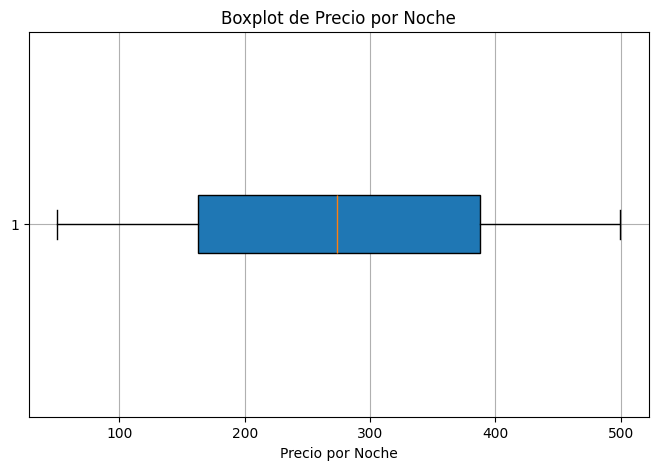

In [35]:
# Reimportar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt

# Verificar si la columna "precio_noche" existe en el DataFrame
if "precio_noche" in df.columns:
    # Convertir la columna a numérico (por si tiene valores en formato string)
    df["precio_noche"] = pd.to_numeric(df["precio_noche"], errors="coerce")

    # Mostrar estadísticas descriptivas para revisar los valores
    stats = df["precio_noche"].describe()
    print("📊 Estadísticas descriptivas de 'precio_noche':\n", stats)

    # Contar valores nulos
    num_nulos = df["precio_noche"].isnull().sum()
    print(f"⚠️ Valores nulos en 'precio_noche': {num_nulos}")

    # Crear el boxplot solo si hay valores válidos
    if df["precio_noche"].dropna().shape[0] > 0:
        plt.figure(figsize=(8, 5))
        plt.boxplot(df["precio_noche"].dropna(), vert=False, patch_artist=True)
        plt.xlabel("Precio por Noche")
        plt.title("Boxplot de Precio por Noche")
        plt.grid(True)
        plt.show()
    else:
        print("❌ No hay valores válidos en 'precio_noche'. No se puede generar el boxplot.")
else:
    print("❌ La columna 'precio_noche' no existe en el DataFrame.")



No hay valores atípicos

In [36]:
mergeo_hoteles_propios = pd.merge(df_hoteles_no_competencia, estrellas, on="nombre_hotel")
mergeo_hoteles_propios

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas_x,ciudad,estrellas_y
0,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,119.96,Hotel Monte Verde,1.0,Madrid,3.103636
1,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,211.53,Hotel Brisas del Mar,5.0,Madrid,3.088015
2,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,378.37,Hotel Camino del Sol,1.0,Madrid,3.067568
3,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,df42ae3d-0b9b-4c06-b22e-939323833ef8,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,4,85.45,Hotel Puerta del Cielo,5.0,Madrid,3.028517
4,99c3dc4f-663c-45f7-849a-ac9313f3746a,a16a9d83-6888-4947-a7ab-ed41203e347c,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,5,309.80,Hotel Encanto Real,1.0,Madrid,3.031311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9823,277edc09-64da-4a99-b6e2-395491a5f1a7,87df00cd-331f-4dda-a12c-6cd4fed91504,Adoración,Cuadrado,adoración.cuadrado@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,305.79,Hotel Jardines del Rey,1.0,Madrid,2.936255
9824,0b1676e5-12a9-48cd-944d-b3d09e1ddf08,02a9ffb9-9de2-4a80-8b14-e20e217af1a6,Edgardo,Sanchez,edgardo.sanchez@example.com,False,2025-02-06,2025-03-01,2025-03-02,16,381.16,Hotel Rincón Sereno,1.0,Madrid,2.998047
9825,58acd6f3-7160-4973-b951-b14188937444,de729428-ec23-4665-a5c9-79e3ec282470,Lorena,Román,lorena.román@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,111.78,Hotel Jardines del Rey,1.0,Madrid,2.936255
9826,af0f6afa-e7d2-410a-8cdd-5eb62b1e4788,e89751f4-3621-4636-81d3-90e2baa709cb,Nadia,Verdugo,nadia.verdugo@example.com,False,2025-02-11,2025-03-01,2025-03-02,2,442.96,Hotel Brisas del Mar,5.0,Madrid,3.088015


In [ ]:
mergeo_hoteles_propios = pd.merge(df_hoteles_no_competencia, precio, on="nombre_hotel")
mergeo_hoteles_propios

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche_x,nombre_hotel,estrellas,ciudad,precio_noche_y
0,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,119.96,Hotel Monte Verde,1.0,Madrid,276.612381
1,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,211.53,Hotel Brisas del Mar,5.0,Madrid,275.225921
2,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,378.37,Hotel Camino del Sol,1.0,Madrid,269.998444
3,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,df42ae3d-0b9b-4c06-b22e-939323833ef8,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,4,85.45,Hotel Puerta del Cielo,5.0,Madrid,280.151243
4,99c3dc4f-663c-45f7-849a-ac9313f3746a,a16a9d83-6888-4947-a7ab-ed41203e347c,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,5,309.80,Hotel Encanto Real,1.0,Madrid,278.243996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9823,277edc09-64da-4a99-b6e2-395491a5f1a7,87df00cd-331f-4dda-a12c-6cd4fed91504,Adoración,Cuadrado,adoración.cuadrado@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,305.79,Hotel Jardines del Rey,1.0,Madrid,272.402335
9824,0b1676e5-12a9-48cd-944d-b3d09e1ddf08,02a9ffb9-9de2-4a80-8b14-e20e217af1a6,Edgardo,Sanchez,edgardo.sanchez@example.com,False,2025-02-06,2025-03-01,2025-03-02,16,381.16,Hotel Rincón Sereno,1.0,Madrid,277.318824
9825,58acd6f3-7160-4973-b951-b14188937444,de729428-ec23-4665-a5c9-79e3ec282470,Lorena,Román,lorena.román@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,111.78,Hotel Jardines del Rey,1.0,Madrid,272.402335
9826,af0f6afa-e7d2-410a-8cdd-5eb62b1e4788,e89751f4-3621-4636-81d3-90e2baa709cb,Nadia,Verdugo,nadia.verdugo@example.com,False,2025-02-11,2025-03-01,2025-03-02,2,442.96,Hotel Brisas del Mar,5.0,Madrid,275.225921


In [38]:
mergeo_hoteles_propios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       9828 non-null   object        
 1   id_cliente       9828 non-null   object        
 2   nombre           9828 non-null   object        
 3   apellido         9828 non-null   object        
 4   mail             9828 non-null   object        
 5   competencia      9828 non-null   bool          
 6   fecha_reserva    9828 non-null   datetime64[ns]
 7   inicio_estancia  9828 non-null   datetime64[ns]
 8   final_estancia   9828 non-null   datetime64[ns]
 9   id_hotel         9828 non-null   int64         
 10  precio_noche_x   9776 non-null   float64       
 11  nombre_hotel     9828 non-null   object        
 12  estrellas        9828 non-null   float64       
 13  ciudad           9828 non-null   object        
 14  precio_noche_y   9828 non-null   float64

In [39]:
mergeo_hoteles_propios = mergeo_hoteles_propios.drop(columns=["precio_noche_x"])
mergeo_hoteles_propios

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,nombre_hotel,estrellas,ciudad,precio_noche_y
0,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,Hotel Monte Verde,1.0,Madrid,276.612381
1,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,Hotel Brisas del Mar,5.0,Madrid,275.225921
2,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,Hotel Camino del Sol,1.0,Madrid,269.998444
3,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,df42ae3d-0b9b-4c06-b22e-939323833ef8,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,4,Hotel Puerta del Cielo,5.0,Madrid,280.151243
4,99c3dc4f-663c-45f7-849a-ac9313f3746a,a16a9d83-6888-4947-a7ab-ed41203e347c,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,5,Hotel Encanto Real,1.0,Madrid,278.243996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9823,277edc09-64da-4a99-b6e2-395491a5f1a7,87df00cd-331f-4dda-a12c-6cd4fed91504,Adoración,Cuadrado,adoración.cuadrado@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,Hotel Jardines del Rey,1.0,Madrid,272.402335
9824,0b1676e5-12a9-48cd-944d-b3d09e1ddf08,02a9ffb9-9de2-4a80-8b14-e20e217af1a6,Edgardo,Sanchez,edgardo.sanchez@example.com,False,2025-02-06,2025-03-01,2025-03-02,16,Hotel Rincón Sereno,1.0,Madrid,277.318824
9825,58acd6f3-7160-4973-b951-b14188937444,de729428-ec23-4665-a5c9-79e3ec282470,Lorena,Román,lorena.román@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,Hotel Jardines del Rey,1.0,Madrid,272.402335
9826,af0f6afa-e7d2-410a-8cdd-5eb62b1e4788,e89751f4-3621-4636-81d3-90e2baa709cb,Nadia,Verdugo,nadia.verdugo@example.com,False,2025-02-11,2025-03-01,2025-03-02,2,Hotel Brisas del Mar,5.0,Madrid,275.225921


In [40]:
mergeo_hoteles_propios = mergeo_hoteles_propios.rename(columns={"precio_noche_y": "precio_noche"})
mergeo_hoteles_propios

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,nombre_hotel,estrellas,ciudad,precio_noche
0,40c4cb55-d1f5-407b-832f-4756b8ff77b4,6ec4d7d2-e382-47cc-94f6-c647577d4035,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,Hotel Monte Verde,1.0,Madrid,276.612381
1,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,aed17fe8-eb18-4f69-bf08-df1afdc339c3,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,Hotel Brisas del Mar,5.0,Madrid,275.225921
2,57d4515a-447d-4067-afcb-9bdcf4e4e915,710a2fbb-264f-426a-aa66-f8fffd146a2d,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,Hotel Camino del Sol,1.0,Madrid,269.998444
3,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,df42ae3d-0b9b-4c06-b22e-939323833ef8,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,4,Hotel Puerta del Cielo,5.0,Madrid,280.151243
4,99c3dc4f-663c-45f7-849a-ac9313f3746a,a16a9d83-6888-4947-a7ab-ed41203e347c,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,5,Hotel Encanto Real,1.0,Madrid,278.243996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9823,277edc09-64da-4a99-b6e2-395491a5f1a7,87df00cd-331f-4dda-a12c-6cd4fed91504,Adoración,Cuadrado,adoración.cuadrado@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,Hotel Jardines del Rey,1.0,Madrid,272.402335
9824,0b1676e5-12a9-48cd-944d-b3d09e1ddf08,02a9ffb9-9de2-4a80-8b14-e20e217af1a6,Edgardo,Sanchez,edgardo.sanchez@example.com,False,2025-02-06,2025-03-01,2025-03-02,16,Hotel Rincón Sereno,1.0,Madrid,277.318824
9825,58acd6f3-7160-4973-b951-b14188937444,de729428-ec23-4665-a5c9-79e3ec282470,Lorena,Román,lorena.román@example.com,False,2025-02-06,2025-03-01,2025-03-02,7,Hotel Jardines del Rey,1.0,Madrid,272.402335
9826,af0f6afa-e7d2-410a-8cdd-5eb62b1e4788,e89751f4-3621-4636-81d3-90e2baa709cb,Nadia,Verdugo,nadia.verdugo@example.com,False,2025-02-11,2025-03-01,2025-03-02,2,Hotel Brisas del Mar,5.0,Madrid,275.225921


In [41]:
df_competencia = pd.read_csv("../data/data_raw/hoteles_competencia.csv", index_col=False)
df_competencia

,nombre_hotel,estrellas,precio_noche
0,ibis Styles Madrid Prado,4.7,161
1,Novotel Madrid Center,4.6,255
2,ibis Madrid Centro las Ventas,4.5,172
3,Novotel Madrid City Las Ventas,4.6,173
4,ibis budget Madrid Vallecas,4.3,107
5,ibis Madrid Aeropuerto Barajas,4.4,116
6,ibis Madrid Alcorcon Tresaguas,4.4,90
7,ibis budget Madrid Aeropuerto,4.0,88
8,ibis Madrid Alcobendas,4.4,85
9,ibis budget Madrid Alcorcon Móstoles,4.5,77


In [42]:
df_hoteles_competencia["id_hotel"].nunique()

10

In [43]:
df_competencia["id_hotel"] = df_hoteles_competencia["id_hotel"].unique()
df_competencia

,nombre_hotel,estrellas,precio_noche,id_hotel
0,ibis Styles Madrid Prado,4.7,161,113
1,Novotel Madrid Center,4.6,255,194
2,ibis Madrid Centro las Ventas,4.5,172,131
3,Novotel Madrid City Las Ventas,4.6,173,114
4,ibis budget Madrid Vallecas,4.3,107,103
5,ibis Madrid Aeropuerto Barajas,4.4,116,181
6,ibis Madrid Alcorcon Tresaguas,4.4,90,128
7,ibis budget Madrid Aeropuerto,4.0,88,186
8,ibis Madrid Alcobendas,4.4,85,135
9,ibis budget Madrid Alcorcon Móstoles,4.5,77,117


In [ ]:
mergeo_competencia = pd.merge(df_hoteles_competencia, df_competencia, on="id_hotel")
mergeo_competencia

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche_x,nombre_hotel_x,estrellas_x,ciudad,nombre_hotel_y,estrellas_y,precio_noche_y
0,5256cc90-139b-43d2-8ec5-412495d751cf,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Feliciana,Cantón,feliciana.cantón@example.com,True,NaT,2025-03-01,2025-03-02,113,NaN,,NaN,,ibis Styles Madrid Prado,4.7,161
1,84fd6209-bd8d-4a92-bfe6-c68ee2c49271,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Leonardo,Hierro,leonardo.hierro@example.com,True,NaT,2025-03-01,2025-03-02,194,NaN,,NaN,,Novotel Madrid Center,4.6,255
2,4d65096e-5f12-4ce7-9fd6-dd20e3cf5194,443a7307-2183-4051-b0bb-26f12fc1f478,Judith,Rivas,judith.rivas@example.com,True,NaT,2025-03-01,2025-03-02,131,NaN,,NaN,,ibis Madrid Centro las Ventas,4.5,172
3,458029ad-cc9b-4d85-8290-fec170bcc02d,e1a34338-a0aa-4b0e-96de-55f884eeb074,Adolfo,Cuervo,adolfo.cuervo@example.com,True,NaT,2025-03-01,2025-03-02,114,NaN,,NaN,,Novotel Madrid City Las Ventas,4.6,173
4,ac0fe86e-90a0-4fe6-a02e-6ea00e9a8621,2949fb90-39ab-4613-b4c1-e238bb56faf3,María Carmen,Navarro,maría carmen.navarro@example.com,True,NaT,2025-03-01,2025-03-02,103,NaN,,NaN,,ibis budget Madrid Vallecas,4.3,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,e856adee-838c-4031-920c-05ec5f1e32e6,7d248367-3444-4bfd-97b3-c56892fa7d97,Jesusa,Espinosa,jesusa.espinosa@example.com,True,NaT,2025-03-01,2025-03-02,135,NaN,,NaN,,ibis Madrid Alcobendas,4.4,85
5168,77134049-6e4f-49b0-a6f8-93b7466b1c22,524c7818-3167-4dc6-bbe3-a75bbc32feaf,Cruz,Hurtado,cruz.hurtado@example.com,True,NaT,2025-03-01,2025-03-02,128,NaN,,NaN,,ibis Madrid Alcorcon Tresaguas,4.4,90
5169,19aef6f3-3e85-4719-9dff-b768d9bfe5a9,fc8320ad-ce4d-4d23-bacd-347b2a2ac24c,Jose Francisco,Cortes,jose francisco.cortes@example.com,True,NaT,2025-03-01,2025-03-02,186,NaN,,NaN,,ibis budget Madrid Aeropuerto,4.0,88
5170,aa092c3e-7fe6-4985-a5a8-cacd38554b1b,8469b819-d96a-4904-9cdd-710764f6301f,Toño,Narváez,toño.narváez@example.com,True,NaT,2025-03-01,2025-03-02,114,NaN,,NaN,,Novotel Madrid City Las Ventas,4.6,173


In [45]:
mergeo_competencia = mergeo_competencia.drop(columns= ["precio_noche_x", "nombre_hotel_x", "estrellas_x"])
mergeo_competencia

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,ciudad,nombre_hotel_y,estrellas_y,precio_noche_y
0,5256cc90-139b-43d2-8ec5-412495d751cf,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Feliciana,Cantón,feliciana.cantón@example.com,True,NaT,2025-03-01,2025-03-02,113,,ibis Styles Madrid Prado,4.7,161
1,84fd6209-bd8d-4a92-bfe6-c68ee2c49271,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Leonardo,Hierro,leonardo.hierro@example.com,True,NaT,2025-03-01,2025-03-02,194,,Novotel Madrid Center,4.6,255
2,4d65096e-5f12-4ce7-9fd6-dd20e3cf5194,443a7307-2183-4051-b0bb-26f12fc1f478,Judith,Rivas,judith.rivas@example.com,True,NaT,2025-03-01,2025-03-02,131,,ibis Madrid Centro las Ventas,4.5,172
3,458029ad-cc9b-4d85-8290-fec170bcc02d,e1a34338-a0aa-4b0e-96de-55f884eeb074,Adolfo,Cuervo,adolfo.cuervo@example.com,True,NaT,2025-03-01,2025-03-02,114,,Novotel Madrid City Las Ventas,4.6,173
4,ac0fe86e-90a0-4fe6-a02e-6ea00e9a8621,2949fb90-39ab-4613-b4c1-e238bb56faf3,María Carmen,Navarro,maría carmen.navarro@example.com,True,NaT,2025-03-01,2025-03-02,103,,ibis budget Madrid Vallecas,4.3,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,e856adee-838c-4031-920c-05ec5f1e32e6,7d248367-3444-4bfd-97b3-c56892fa7d97,Jesusa,Espinosa,jesusa.espinosa@example.com,True,NaT,2025-03-01,2025-03-02,135,,ibis Madrid Alcobendas,4.4,85
5168,77134049-6e4f-49b0-a6f8-93b7466b1c22,524c7818-3167-4dc6-bbe3-a75bbc32feaf,Cruz,Hurtado,cruz.hurtado@example.com,True,NaT,2025-03-01,2025-03-02,128,,ibis Madrid Alcorcon Tresaguas,4.4,90
5169,19aef6f3-3e85-4719-9dff-b768d9bfe5a9,fc8320ad-ce4d-4d23-bacd-347b2a2ac24c,Jose Francisco,Cortes,jose francisco.cortes@example.com,True,NaT,2025-03-01,2025-03-02,186,,ibis budget Madrid Aeropuerto,4.0,88
5170,aa092c3e-7fe6-4985-a5a8-cacd38554b1b,8469b819-d96a-4904-9cdd-710764f6301f,Toño,Narváez,toño.narváez@example.com,True,NaT,2025-03-01,2025-03-02,114,,Novotel Madrid City Las Ventas,4.6,173


In [46]:
mergeo_competencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       5172 non-null   object        
 1   id_cliente       5172 non-null   object        
 2   nombre           5172 non-null   object        
 3   apellido         5172 non-null   object        
 4   mail             5172 non-null   object        
 5   competencia      5172 non-null   bool          
 6   fecha_reserva    0 non-null      datetime64[ns]
 7   inicio_estancia  5172 non-null   datetime64[ns]
 8   final_estancia   5172 non-null   datetime64[ns]
 9   id_hotel         5172 non-null   int64         
 10  ciudad           5172 non-null   object        
 11  nombre_hotel_y   5172 non-null   object        
 12  estrellas_y      5172 non-null   float64       
 13  precio_noche_y   5172 non-null   int64         
dtypes: bool(1), datetime64[ns](3), float64(1

In [47]:
mergeo_competencia =mergeo_competencia.rename(columns={"nombre_hotel_y": "nombre_hotel", "estrellas_y": "estrellas", "precio_noche_y": "precio_noche"})
mergeo_competencia

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,ciudad,nombre_hotel,estrellas,precio_noche
0,5256cc90-139b-43d2-8ec5-412495d751cf,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Feliciana,Cantón,feliciana.cantón@example.com,True,NaT,2025-03-01,2025-03-02,113,,ibis Styles Madrid Prado,4.7,161
1,84fd6209-bd8d-4a92-bfe6-c68ee2c49271,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Leonardo,Hierro,leonardo.hierro@example.com,True,NaT,2025-03-01,2025-03-02,194,,Novotel Madrid Center,4.6,255
2,4d65096e-5f12-4ce7-9fd6-dd20e3cf5194,443a7307-2183-4051-b0bb-26f12fc1f478,Judith,Rivas,judith.rivas@example.com,True,NaT,2025-03-01,2025-03-02,131,,ibis Madrid Centro las Ventas,4.5,172
3,458029ad-cc9b-4d85-8290-fec170bcc02d,e1a34338-a0aa-4b0e-96de-55f884eeb074,Adolfo,Cuervo,adolfo.cuervo@example.com,True,NaT,2025-03-01,2025-03-02,114,,Novotel Madrid City Las Ventas,4.6,173
4,ac0fe86e-90a0-4fe6-a02e-6ea00e9a8621,2949fb90-39ab-4613-b4c1-e238bb56faf3,María Carmen,Navarro,maría carmen.navarro@example.com,True,NaT,2025-03-01,2025-03-02,103,,ibis budget Madrid Vallecas,4.3,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,e856adee-838c-4031-920c-05ec5f1e32e6,7d248367-3444-4bfd-97b3-c56892fa7d97,Jesusa,Espinosa,jesusa.espinosa@example.com,True,NaT,2025-03-01,2025-03-02,135,,ibis Madrid Alcobendas,4.4,85
5168,77134049-6e4f-49b0-a6f8-93b7466b1c22,524c7818-3167-4dc6-bbe3-a75bbc32feaf,Cruz,Hurtado,cruz.hurtado@example.com,True,NaT,2025-03-01,2025-03-02,128,,ibis Madrid Alcorcon Tresaguas,4.4,90
5169,19aef6f3-3e85-4719-9dff-b768d9bfe5a9,fc8320ad-ce4d-4d23-bacd-347b2a2ac24c,Jose Francisco,Cortes,jose francisco.cortes@example.com,True,NaT,2025-03-01,2025-03-02,186,,ibis budget Madrid Aeropuerto,4.0,88
5170,aa092c3e-7fe6-4985-a5a8-cacd38554b1b,8469b819-d96a-4904-9cdd-710764f6301f,Toño,Narváez,toño.narváez@example.com,True,NaT,2025-03-01,2025-03-02,114,,Novotel Madrid City Las Ventas,4.6,173


In [48]:
# Reemplazar los valores nulos en la columna "fecha_reserva" con la fecha "2025-02-22"
mergeo_competencia["fecha_reserva"] = mergeo_competencia["fecha_reserva"].fillna("2025-02-22")
mergeo_competencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       5172 non-null   object        
 1   id_cliente       5172 non-null   object        
 2   nombre           5172 non-null   object        
 3   apellido         5172 non-null   object        
 4   mail             5172 non-null   object        
 5   competencia      5172 non-null   bool          
 6   fecha_reserva    5172 non-null   datetime64[ns]
 7   inicio_estancia  5172 non-null   datetime64[ns]
 8   final_estancia   5172 non-null   datetime64[ns]
 9   id_hotel         5172 non-null   int64         
 10  ciudad           5172 non-null   object        
 11  nombre_hotel     5172 non-null   object        
 12  estrellas        5172 non-null   float64       
 13  precio_noche     5172 non-null   int64         
dtypes: bool(1), datetime64[ns](3), float64(1

In [49]:
mergeo_competencia = mergeo_competencia.reindex(columns=mergeo_hoteles_propios.columns)

In [50]:
mergeo_competencia.head()

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,nombre_hotel,estrellas,ciudad,precio_noche
0,5256cc90-139b-43d2-8ec5-412495d751cf,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Feliciana,Cantón,feliciana.cantón@example.com,True,2025-02-22,2025-03-01,2025-03-02,113,ibis Styles Madrid Prado,4.7,,161
1,84fd6209-bd8d-4a92-bfe6-c68ee2c49271,346f2a77-33f4-4b2d-82f3-e8501e21b28d,Leonardo,Hierro,leonardo.hierro@example.com,True,2025-02-22,2025-03-01,2025-03-02,194,Novotel Madrid Center,4.6,,255
2,4d65096e-5f12-4ce7-9fd6-dd20e3cf5194,443a7307-2183-4051-b0bb-26f12fc1f478,Judith,Rivas,judith.rivas@example.com,True,2025-02-22,2025-03-01,2025-03-02,131,ibis Madrid Centro las Ventas,4.5,,172
3,458029ad-cc9b-4d85-8290-fec170bcc02d,e1a34338-a0aa-4b0e-96de-55f884eeb074,Adolfo,Cuervo,adolfo.cuervo@example.com,True,2025-02-22,2025-03-01,2025-03-02,114,Novotel Madrid City Las Ventas,4.6,,173
4,ac0fe86e-90a0-4fe6-a02e-6ea00e9a8621,2949fb90-39ab-4613-b4c1-e238bb56faf3,María Carmen,Navarro,maría carmen.navarro@example.com,True,2025-02-22,2025-03-01,2025-03-02,103,ibis budget Madrid Vallecas,4.3,,107


In [51]:
mergeo_competencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       5172 non-null   object        
 1   id_cliente       5172 non-null   object        
 2   nombre           5172 non-null   object        
 3   apellido         5172 non-null   object        
 4   mail             5172 non-null   object        
 5   competencia      5172 non-null   bool          
 6   fecha_reserva    5172 non-null   datetime64[ns]
 7   inicio_estancia  5172 non-null   datetime64[ns]
 8   final_estancia   5172 non-null   datetime64[ns]
 9   id_hotel         5172 non-null   int64         
 10  nombre_hotel     5172 non-null   object        
 11  estrellas        5172 non-null   float64       
 12  ciudad           5172 non-null   object        
 13  precio_noche     5172 non-null   int64         
dtypes: bool(1), datetime64[ns](3), float64(1

In [52]:
mergeo_hoteles_propios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       9828 non-null   object        
 1   id_cliente       9828 non-null   object        
 2   nombre           9828 non-null   object        
 3   apellido         9828 non-null   object        
 4   mail             9828 non-null   object        
 5   competencia      9828 non-null   bool          
 6   fecha_reserva    9828 non-null   datetime64[ns]
 7   inicio_estancia  9828 non-null   datetime64[ns]
 8   final_estancia   9828 non-null   datetime64[ns]
 9   id_hotel         9828 non-null   int64         
 10  nombre_hotel     9828 non-null   object        
 11  estrellas        9828 non-null   float64       
 12  ciudad           9828 non-null   object        
 13  precio_noche     9828 non-null   float64       
dtypes: bool(1), datetime64[ns](3), float64(2

In [ ]:
hoteles_mergeo = pd.concat([mergeo_hoteles_propios, mergeo_competencia], axis=0)

In [54]:
hoteles_mergeo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 5171
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   id_cliente       15000 non-null  object        
 2   nombre           15000 non-null  object        
 3   apellido         15000 non-null  object        
 4   mail             15000 non-null  object        
 5   competencia      15000 non-null  bool          
 6   fecha_reserva    15000 non-null  datetime64[ns]
 7   inicio_estancia  15000 non-null  datetime64[ns]
 8   final_estancia   15000 non-null  datetime64[ns]
 9   id_hotel         15000 non-null  int64         
 10  nombre_hotel     15000 non-null  object        
 11  estrellas        15000 non-null  float64       
 12  ciudad           15000 non-null  object        
 13  precio_noche     15000 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(2), i

In [55]:
hoteles_mergeo =hoteles_mergeo.rename(columns={"estrellas": "valoración"})
hoteles_mergeo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 5171
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   id_cliente       15000 non-null  object        
 2   nombre           15000 non-null  object        
 3   apellido         15000 non-null  object        
 4   mail             15000 non-null  object        
 5   competencia      15000 non-null  bool          
 6   fecha_reserva    15000 non-null  datetime64[ns]
 7   inicio_estancia  15000 non-null  datetime64[ns]
 8   final_estancia   15000 non-null  datetime64[ns]
 9   id_hotel         15000 non-null  int64         
 10  nombre_hotel     15000 non-null  object        
 11  valoración       15000 non-null  float64       
 12  ciudad           15000 non-null  object        
 13  precio_noche     15000 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(2), i

In [56]:
# Crear un diccionario con un ID único para cada cliente basado en su correo electrónico
emails_unicos = hoteles_mergeo['mail'].unique()
email_a_id = {email: f"cliente{i+1}" for i, email in enumerate(emails_unicos)}

# Aplicar el diccionario para crear la nueva columna con el ID del cliente
hoteles_mergeo['id_cliente_nuevo'] = hoteles_mergeo['mail'].map(email_a_id)

# Eliminar la columna antigua de id_cliente
hoteles_mergeo.drop(columns=['id_cliente'], inplace=True)

# Renombrar la nueva columna con el nombre de la columna original
hoteles_mergeo.rename(columns={'id_cliente_nuevo': 'id_cliente'}, inplace=True)
hoteles_mergeo.head()

,id_reserva,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,nombre_hotel,valoración,ciudad,precio_noche,id_cliente
0,40c4cb55-d1f5-407b-832f-4756b8ff77b4,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,Hotel Monte Verde,1.0,Madrid,276.612381,cliente1
1,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,Hotel Brisas del Mar,5.0,Madrid,275.225921,cliente2
2,57d4515a-447d-4067-afcb-9bdcf4e4e915,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,Hotel Camino del Sol,1.0,Madrid,269.998444,cliente3
3,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,4,Hotel Puerta del Cielo,5.0,Madrid,280.151243,cliente4
4,99c3dc4f-663c-45f7-849a-ac9313f3746a,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,5,Hotel Encanto Real,1.0,Madrid,278.243996,cliente5


In [57]:
hoteles_mergeo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 5171
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   nombre           15000 non-null  object        
 2   apellido         15000 non-null  object        
 3   mail             15000 non-null  object        
 4   competencia      15000 non-null  bool          
 5   fecha_reserva    15000 non-null  datetime64[ns]
 6   inicio_estancia  15000 non-null  datetime64[ns]
 7   final_estancia   15000 non-null  datetime64[ns]
 8   id_hotel         15000 non-null  int64         
 9   nombre_hotel     15000 non-null  object        
 10  valoración       15000 non-null  float64       
 11  ciudad           15000 non-null  object        
 12  precio_noche     15000 non-null  float64       
 13  id_cliente       15000 non-null  object        
dtypes: bool(1), datetime64[ns](3), float64(2), i

In [58]:
print(hoteles_mergeo.columns)  # Muestra las columnas disponibles

Index(['id_reserva', 'nombre', 'apellido', 'mail', 'competencia',
       'fecha_reserva', 'inicio_estancia', 'final_estancia', 'id_hotel',
       'nombre_hotel', 'valoración', 'ciudad', 'precio_noche', 'id_cliente'],
      dtype='object')


In [59]:
if 'ciudad' in hoteles_mergeo.columns:  # Verifica que la columna exista
    if hoteles_mergeo['ciudad'].nunique() == 1 and hoteles_mergeo['ciudad'].unique()[0] == "Madrid":
        hoteles_mergeo['id_ciudad'] = 1  # Asignar 1 a todas las filas
        hoteles_mergeo['id_ciudad'] = hoteles_mergeo['id_ciudad'].astype(int)  # Convertir a INT
    else:
        print("⚠️ Atención: Hay más de una ciudad en el DataFrame.")
else:
    print("❌ Error: La columna 'ciudad' no existe en el DataFrame.")

⚠️ Atención: Hay más de una ciudad en el DataFrame.


In [60]:
# Reemplazar valores nulos en la columna "ciudad" con "Madrid" de manera segura
hoteles_mergeo['ciudad'] = hoteles_mergeo['ciudad'].fillna('Madrid')

# Asegurar que todas las filas en la columna "ciudad" contengan "Madrid"
hoteles_mergeo['ciudad'] = 'Madrid'

# Crear la columna "id_ciudad" con el valor 1 para todas las filas
hoteles_mergeo['id_ciudad'] = 1

# Convertir la columna "id_ciudad" a tipo entero
hoteles_mergeo['id_ciudad'] = hoteles_mergeo['id_ciudad'].astype(int)
hoteles_mergeo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 5171
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   nombre           15000 non-null  object        
 2   apellido         15000 non-null  object        
 3   mail             15000 non-null  object        
 4   competencia      15000 non-null  bool          
 5   fecha_reserva    15000 non-null  datetime64[ns]
 6   inicio_estancia  15000 non-null  datetime64[ns]
 7   final_estancia   15000 non-null  datetime64[ns]
 8   id_hotel         15000 non-null  int64         
 9   nombre_hotel     15000 non-null  object        
 10  valoración       15000 non-null  float64       
 11  ciudad           15000 non-null  object        
 12  precio_noche     15000 non-null  float64       
 13  id_cliente       15000 non-null  object        
 14  id_ciudad        15000 non-null  int64      

In [61]:
hoteles_mergeo.head()

,id_reserva,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,nombre_hotel,valoración,ciudad,precio_noche,id_cliente,id_ciudad
0,40c4cb55-d1f5-407b-832f-4756b8ff77b4,Maite,Calatayud,maite.calatayud@example.com,False,2025-02-09,2025-03-01,2025-03-02,1,Hotel Monte Verde,1.0,Madrid,276.612381,cliente1,1
1,f2ce8df5-7844-43e1-8c0f-97ce7a208f21,Tecla,Bonet,tecla.bonet@example.com,False,2025-02-08,2025-03-01,2025-03-02,2,Hotel Brisas del Mar,5.0,Madrid,275.225921,cliente2,1
2,57d4515a-447d-4067-afcb-9bdcf4e4e915,Amílcar,Andrés,amílcar.andrés@example.com,False,2025-02-02,2025-03-01,2025-03-02,3,Hotel Camino del Sol,1.0,Madrid,269.998444,cliente3,1
3,ccbd9fe9-5a60-4f6f-bed3-73a7158ecba7,Joan,Vazquez,joan.vazquez@example.com,False,2025-02-08,2025-03-01,2025-03-02,4,Hotel Puerta del Cielo,5.0,Madrid,280.151243,cliente4,1
4,99c3dc4f-663c-45f7-849a-ac9313f3746a,Chelo,Flor,chelo.flor@example.com,False,2025-02-09,2025-03-01,2025-03-02,5,Hotel Encanto Real,1.0,Madrid,278.243996,cliente5,1


In [ ]:
# Renombrar la columna ciudad
hoteles_mergeo.rename(columns={'ciudad': 'nombre_ciudad', 'valoración': 'valoracion'}, inplace=True)
hoteles_mergeo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 5171
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   nombre           15000 non-null  object        
 2   apellido         15000 non-null  object        
 3   mail             15000 non-null  object        
 4   competencia      15000 non-null  bool          
 5   fecha_reserva    15000 non-null  datetime64[ns]
 6   inicio_estancia  15000 non-null  datetime64[ns]
 7   final_estancia   15000 non-null  datetime64[ns]
 8   id_hotel         15000 non-null  int64         
 9   nombre_hotel     15000 non-null  object        
 10  valoracion       15000 non-null  float64       
 11  nombre_ciudad    15000 non-null  object        
 12  precio_noche     15000 non-null  float64       
 13  id_cliente       15000 non-null  object        
 14  id_ciudad        15000 non-null  int64      

In [63]:
hoteles_mergeo.to_pickle('../data/data_transform/reservas_hoteles_limpio.pkl')